<a href="https://colab.research.google.com/github/shohan007/ML-Engineered-Tissue-Evaluation/blob/main/dis_analysis_namrc22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import sys
from google.colab import drive
drive.mount('/content/drive')
sys.path.append(r"/content/drive/MyDrive/")

Mounted at /content/drive


In [ ]:
import sys, os, json
import numpy as np
import pandas as pd
import seaborn as sns
import argparse, progressbar
import matplotlib.pyplot as plt
from matplotlib.figure import Figure
from matplotlib.axes import Axes
from typing import List

sns.set()


In [ ]:
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models

In [ ]:
# import the necessary packages
from imutils import paths
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from loader_util.preprocessing import ImageToArrayPreprocessor, AspectAwarePreprocessor, SimplePreProcessor, MeanPreprocessor
from loader_util.io import HDF5DatasetGenerator
from loader_util.datasets import SimpleDatasetLoader
from loader_util.nn.conv import FCHeadNet
from loader_util.callbacks import EpochCheckpoint, TrainingMonitor
##
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Conv2D, Activation, Flatten, Dense, BatchNormalization, MaxPooling2D, AveragePooling2D, Dropout, LSTM, RNN, Conv1D, MaxPooling1D, GlobalMaxPooling1D
from tensorflow.keras.layers import Input, concatenate
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop, SGD
from tensorflow.keras.regularizers import l2
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.utils import plot_model

In [ ]:
# read the TS csv
cwd = os.getcwd()
data_path = f"/content/drive/MyDrive/ImageDatasets/namrc2022/dis_data.csv"
data = pd.read_csv(data_path)
data.head()

,Date,Design,DeltaP
0,20/11/2020 13:30:04,1.0,1.506
1,20/11/2020 13:30:34,1.0,1.273
2,20/11/2020 13:31:04,1.0,1.384
3,20/11/2020 13:31:34,1.0,1.516
4,20/11/2020 13:32:04,1.0,1.428


In [ ]:
design1 = data[data["Design"] == 1]["DeltaP"].values
design2 = data[data["Design"] == 2]["DeltaP"].values
design3 = data[data["Design"] == 3]["DeltaP"].values
design4 = data[data["Design"] == 4]["DeltaP"].values

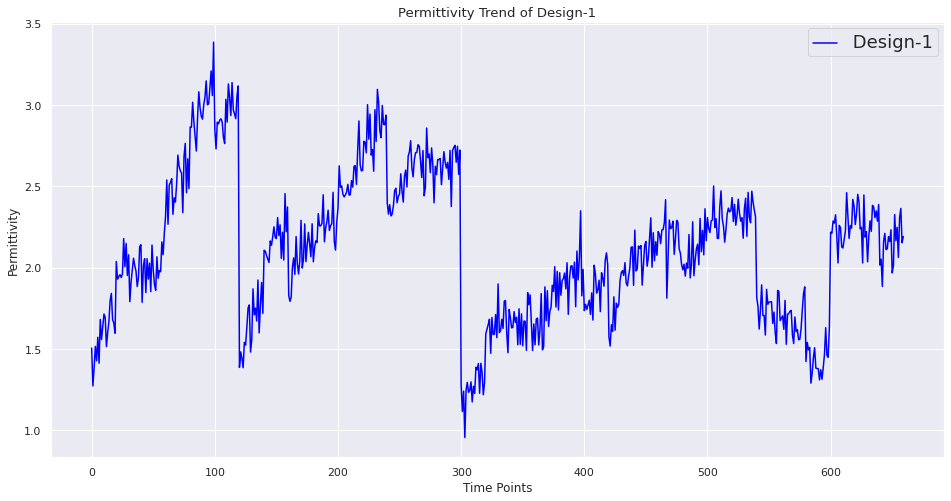

In [ ]:
f, ax = plt.subplots(1,1, figsize=(16, 8)) # type: Figure, Axes
n = range(len(design1))
sns.set(font_scale=1.1)
sns.lineplot(x=n, y=design1, color="blue", label=" Design-1", ax=ax)
ax.set_title("Permittivity Trend of Design-1")
ax.set_xlabel("Time Points")
ax.set_ylabel("Permittivity")
plt.setp(ax.get_legend().get_texts(), fontsize='18'); # for legend text
plt.show()

In [ ]:
# make supervised dataset
# build the dataset
T = 10
def make_supervised_dataset(series):

    X = []
    Y = []

    for t in range(len(series) - T):  # will go upto 989 inclusive
        X.append(series[t:t + T])
        Y.append(series[t + T])

    N = len(X)
    X = np.array(X).reshape((-1, T))
    Y = np.array(Y)
    print(f"[INFO] shape of X: {X.shape} and Y: {Y.shape}......")
    return X, Y, N

In [ ]:
X, Y, N = make_supervised_dataset(design1)

[INFO] shape of X: (650, 10) and Y: (650,)......


In [ ]:
xtrain, ytrain = X[:-N // 2], Y[:-N // 2]
xtest, ytest = X[-N // 2:], Y[-N // 2:]

# ANN

In [ ]:
# basic ANN
i = Input(shape=(T, )) # NxTxD  we have onl;y one feature so D=1
x = Dense(32, activation="relu")(i)
x = Dense(1)(x)  # only one output - one step predictor
model = Model(i, x)

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 10)]              0         
                                                                 
 dense (Dense)               (None, 32)                352       
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 385
Trainable params: 385
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(loss="mse", optimizer="adam", metrics=["mse"])

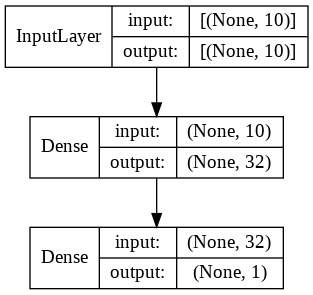

In [ ]:
plot_model(model, show_shapes=True, show_layer_names=False)

In [ ]:
r = model.fit(xtrain, ytrain, epochs=100, validation_data=(xtest, ytest), verbose=1)

Epoch 1/100
11/11 [==============================] - 1s 22ms/step - loss: 7.2790 - mse: 7.2790 - val_loss: 3.8034 - val_mse: 3.8034
Epoch 2/100
11/11 [==============================] - 0s 6ms/step - loss: 4.1359 - mse: 4.1359 - val_loss: 1.9785 - val_mse: 1.9785
Epoch 3/100
11/11 [==============================] - 0s 5ms/step - loss: 2.0551 - mse: 2.0551 - val_loss: 0.8642 - val_mse: 0.8642
Epoch 4/100
11/11 [==============================] - 0s 6ms/step - loss: 0.8544 - mse: 0.8544 - val_loss: 0.2843 - val_mse: 0.2843
Epoch 5/100
11/11 [==============================] - 0s 6ms/step - loss: 0.2880 - mse: 0.2880 - val_loss: 0.0584 - val_mse: 0.0584
Epoch 6/100
11/11 [==============================] - 0s 5ms/step - loss: 0.1090 - mse: 0.1090 - val_loss: 0.0409 - val_mse: 0.0409
Epoch 7/100
11/11 [==============================] - 0s 6ms/step - loss: 0.1080 - mse: 0.1080 - val_loss: 0.0461 - val_mse: 0.0461
Epoch 8/100
11/11 [==============================] - 0s 6ms/step - loss: 0.1013 - 

In [ ]:
mse = r.history["val_mse"][-5:]
print(f"avg_mse: {np.mean(mse)} std_dev: {np.std(mse)}")

avg_mse: 0.026127057895064355 std_dev: 0.0002770654602513848


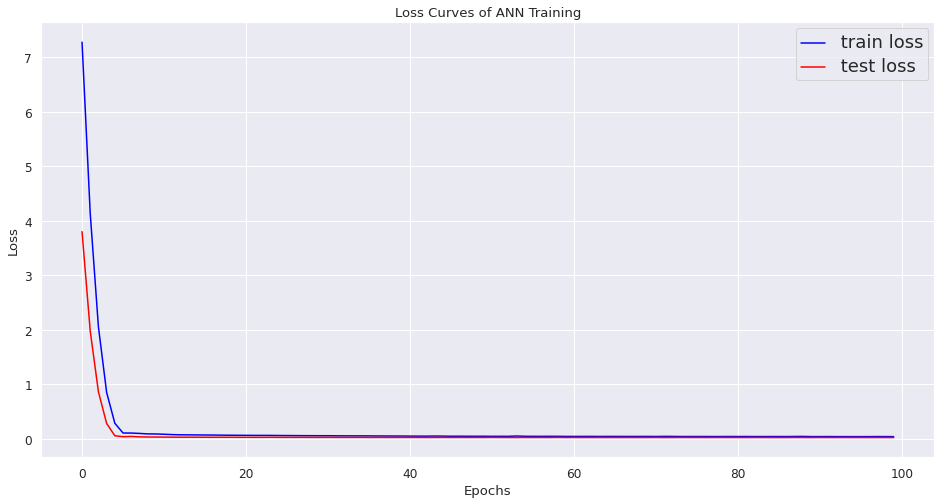

In [ ]:
f, ax = plt.subplots(1,1, figsize=(16, 8)) # type: Figure, Axes
n = range(100)
sns.set(font_scale=1.1)
sns.lineplot(x=n, y=r.history["loss"], color="blue", label=" train loss", ax=ax)
sns.lineplot(x=n, y=r.history["val_loss"], color="red", label=" test loss", ax=ax)
ax.set_title("Loss Curves of ANN Training")
ax.set_xlabel("Epochs")
ax.set_ylabel("Loss")
plt.setp(ax.get_legend().get_texts(), fontsize='18'); # for legend text
plt.show()


# plt.plot(r.history["loss"], label="train_loss")
# plt.plot(r.history["val_loss"], label="test_loss")
# plt.legend()

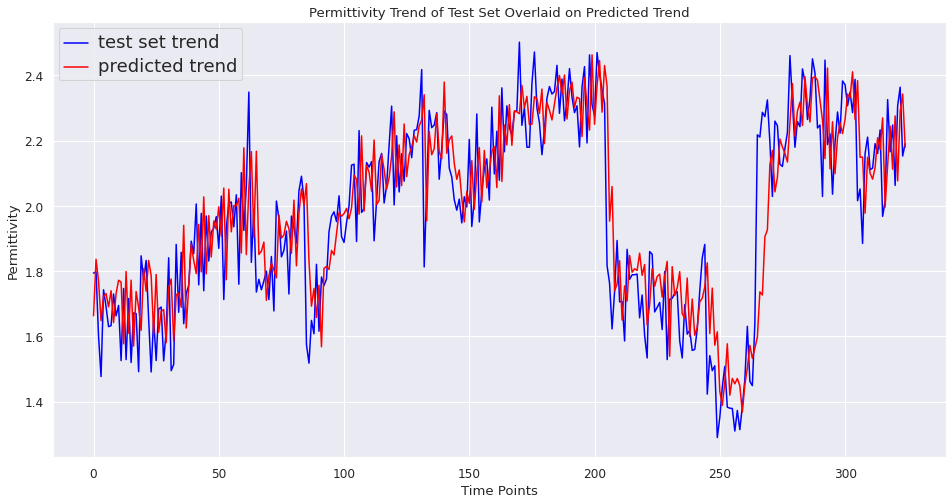

In [ ]:
f, ax = plt.subplots(1,1, figsize=(16, 8)) # type: Figure, Axes
n = range(len(ytest))
sns.set(font_scale=1.1)
sns.lineplot(x=n, y=ytest, label="test set trend", color="blue", ax=ax)
sns.lineplot(x=n, y=model.predict(xtest).flatten(), label="predicted trend", ax=ax, color="red")
ax.set_title("Permittivity Trend of Test Set Overlaid on Predicted Trend")
ax.set_xlabel("Time Points")
ax.set_ylabel("Permittivity")
plt.setp(ax.get_legend().get_texts(), fontsize='18'); # for legend text
plt.show()




# CNN

In [ ]:
# make supervised dataset
# build the dataset
T = 10


def make_supervised_dataset(series):
    X = []
    Y = []

    for t in range(len(series) - T):  # will go upto 989 inclusive
        X.append(series[t:t + T])
        Y.append(series[t + T])

    N = len(X)
    X = np.array(X).reshape((-1, T, 1))
    Y = np.array(Y)
    print(f"[INFO] shape of X: {X.shape} and Y: {Y.shape}......")
    return X, Y, N


X, Y, N = make_supervised_dataset(design1)

[INFO] shape of X: (650, 10, 1) and Y: (650,)......


In [ ]:
xtrain, ytrain = X[:-N // 2], Y[:-N // 2]
xtest, ytest = X[-N // 2:], Y[-N // 2:]

In [ ]:
# CNN
i = Input(shape=(T, 1))
x = Conv1D(16, 3, activation="relu")(i)
x = MaxPooling1D(2)(x)
x = Conv1D(32, 3, activation="relu")(x)
x = GlobalMaxPooling1D()(x)
x = Dense(1)(x)
model_cnn = Model(i, x)
model_cnn.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 10, 1)]           0         
                                                                 
 conv1d (Conv1D)             (None, 8, 16)             64        
                                                                 
 max_pooling1d (MaxPooling1D  (None, 4, 16)            0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 2, 32)             1568      
                                                                 
 global_max_pooling1d (Globa  (None, 32)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense_2 (Dense)             (None, 1)                 33  

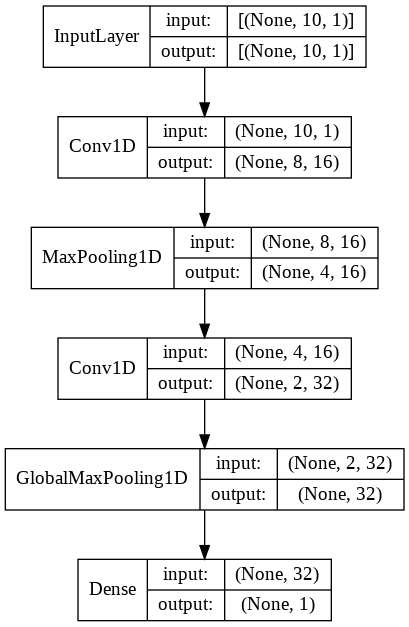

In [ ]:
plot_model(model_cnn, show_shapes=True, show_layer_names=False)

In [ ]:
model_cnn.compile(loss="mse", optimizer="adam", metrics=["mse"])
r = model_cnn.fit(xtrain, ytrain, epochs=100, validation_data=(xtest, ytest), verbose=1)

Epoch 1/100
11/11 [==============================] - 1s 24ms/step - loss: 6.9783 - mse: 6.9783 - val_loss: 3.5269 - val_mse: 3.5269
Epoch 2/100
11/11 [==============================] - 0s 7ms/step - loss: 3.6981 - mse: 3.6981 - val_loss: 1.5073 - val_mse: 1.5073
Epoch 3/100
11/11 [==============================] - 0s 7ms/step - loss: 1.3905 - mse: 1.3905 - val_loss: 0.3659 - val_mse: 0.3659
Epoch 4/100
11/11 [==============================] - 0s 6ms/step - loss: 0.3270 - mse: 0.3270 - val_loss: 0.0353 - val_mse: 0.0353
Epoch 5/100
11/11 [==============================] - 0s 5ms/step - loss: 0.1141 - mse: 0.1141 - val_loss: 0.0605 - val_mse: 0.0605
Epoch 6/100
11/11 [==============================] - 0s 6ms/step - loss: 0.1330 - mse: 0.1330 - val_loss: 0.0399 - val_mse: 0.0399
Epoch 7/100
11/11 [==============================] - 0s 6ms/step - loss: 0.1053 - mse: 0.1053 - val_loss: 0.0313 - val_mse: 0.0313
Epoch 8/100
11/11 [==============================] - 0s 6ms/step - loss: 0.1048 - 

In [ ]:
mse = r.history["val_mse"][-5:]
print(f"avg_mse: {np.mean(mse)} std_dev: {np.std(mse)}")

avg_mse: 0.024316126480698586 std_dev: 0.0015762011831455317


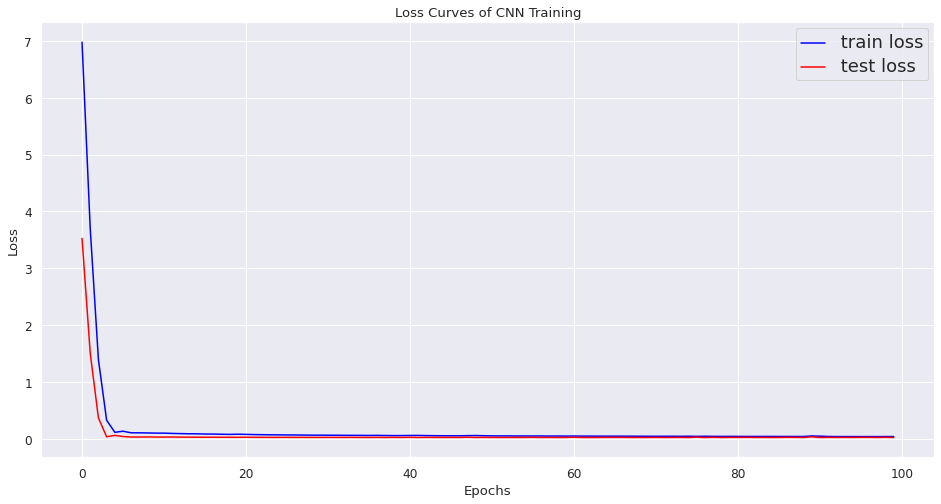

In [ ]:
f, ax = plt.subplots(1,1, figsize=(16, 8)) # type: Figure, Axes
n = range(100)
sns.set(font_scale=1.1)
sns.lineplot(x=n, y=r.history["loss"], color="blue", label=" train loss", ax=ax)
sns.lineplot(x=n, y=r.history["val_loss"], color="red", label=" test loss", ax=ax)
ax.set_title("Loss Curves of CNN Training")
ax.set_xlabel("Epochs")
ax.set_ylabel("Loss")
plt.setp(ax.get_legend().get_texts(), fontsize='18'); # for legend text
plt.show()


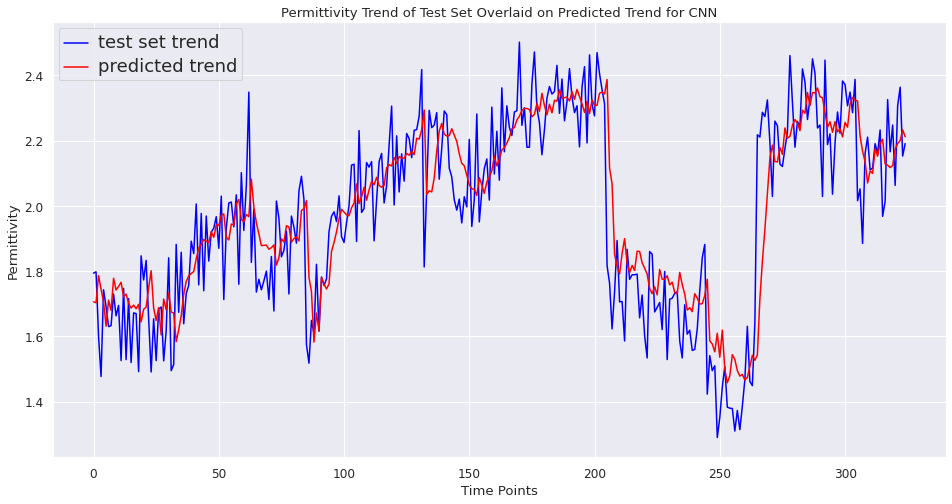

In [ ]:

f, ax = plt.subplots(1,1, figsize=(16, 8)) # type: Figure, Axes
n = range(len(ytest))
sns.set(font_scale=1.1)
sns.lineplot(x=n, y=ytest, label="test set trend", color="blue", ax=ax)
sns.lineplot(x=n, y=model_cnn.predict(xtest).flatten(), label="predicted trend", ax=ax, color="red")
ax.set_title("Permittivity Trend of Test Set Overlaid on Predicted Trend for CNN")
ax.set_xlabel("Time Points")
ax.set_ylabel("Permittivity")
plt.setp(ax.get_legend().get_texts(), fontsize='18'); # for legend text
plt.show()


# RNN

In [ ]:
i = Input(shape=(T, 1))
x = LSTM(24)(i)
x = Dense(1)(x)
model_lstm = Model(i, x)
model_lstm.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 10, 1)]           0         
                                                                 
 lstm (LSTM)                 (None, 24)                2496      
                                                                 
 dense_3 (Dense)             (None, 1)                 25        
                                                                 
Total params: 2,521
Trainable params: 2,521
Non-trainable params: 0
_________________________________________________________________


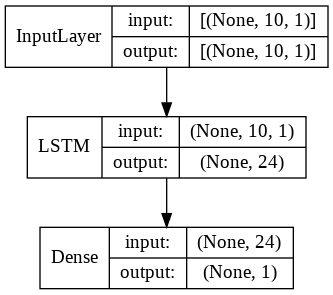

In [ ]:
plot_model(model_lstm, show_layer_names=False, show_shapes=True)

In [ ]:
model_lstm.compile(loss="mse", optimizer="adam", metrics=["mse"])
r = model_lstm.fit(xtrain, ytrain, epochs=100, validation_data=(xtest, ytest), verbose=1)

Epoch 1/100
11/11 [==============================] - 3s 62ms/step - loss: 5.9305 - mse: 5.9305 - val_loss: 3.4116 - val_mse: 3.4116
Epoch 2/100
11/11 [==============================] - 0s 11ms/step - loss: 4.0835 - mse: 4.0835 - val_loss: 2.1187 - val_mse: 2.1187
Epoch 3/100
11/11 [==============================] - 0s 11ms/step - loss: 2.6698 - mse: 2.6698 - val_loss: 1.1511 - val_mse: 1.1511
Epoch 4/100
11/11 [==============================] - 0s 11ms/step - loss: 1.6168 - mse: 1.6168 - val_loss: 0.5064 - val_mse: 0.5064
Epoch 5/100
11/11 [==============================] - 0s 15ms/step - loss: 0.9092 - mse: 0.9092 - val_loss: 0.1792 - val_mse: 0.1792
Epoch 6/100
11/11 [==============================] - 0s 11ms/step - loss: 0.5133 - mse: 0.5133 - val_loss: 0.0803 - val_mse: 0.0803
Epoch 7/100
11/11 [==============================] - 0s 14ms/step - loss: 0.3205 - mse: 0.3205 - val_loss: 0.1036 - val_mse: 0.1036
Epoch 8/100
11/11 [==============================] - 0s 11ms/step - loss: 0.

In [ ]:
mse = r.history["val_mse"][-5:]
print(f"avg_mse: {np.mean(mse)} std_dev: {np.std(mse)}")

avg_mse: 0.021893129125237464 std_dev: 0.0006270938073771294


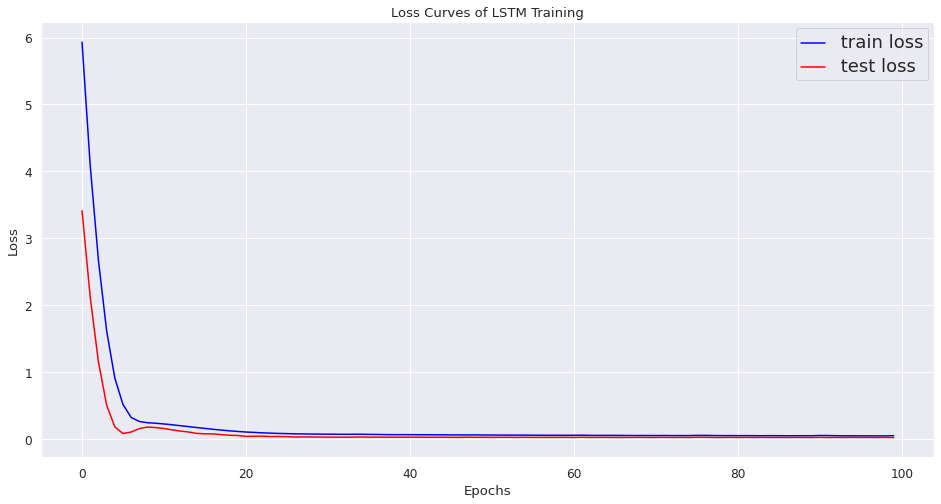

In [ ]:
f, ax = plt.subplots(1,1, figsize=(16, 8)) # type: Figure, Axes
n = range(100)
sns.set(font_scale=1.1)
sns.lineplot(x=n, y=r.history["loss"], color="blue", label=" train loss", ax=ax)
sns.lineplot(x=n, y=r.history["val_loss"], color="red", label=" test loss", ax=ax)
ax.set_title("Loss Curves of LSTM Training")
ax.set_xlabel("Epochs")
ax.set_ylabel("Loss")
plt.setp(ax.get_legend().get_texts(), fontsize='18'); # for legend text
plt.show()


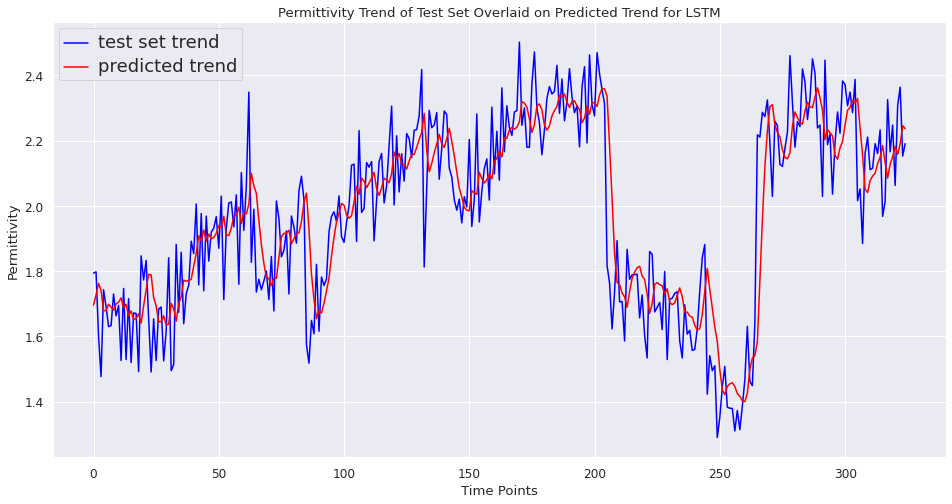

In [ ]:

f, ax = plt.subplots(1,1, figsize=(16, 8)) # type: Figure, Axes
n = range(len(ytest))
sns.set(font_scale=1.1)
sns.lineplot(x=n, y=ytest, label="test set trend", color="blue", ax=ax)
sns.lineplot(x=n, y=model_lstm.predict(xtest).flatten(), label="predicted trend", ax=ax, color="red")
ax.set_title("Permittivity Trend of Test Set Overlaid on Predicted Trend for LSTM")
ax.set_xlabel("Time Points")
ax.set_ylabel("Permittivity")
plt.setp(ax.get_legend().get_texts(), fontsize='18'); # for legend text
plt.show()

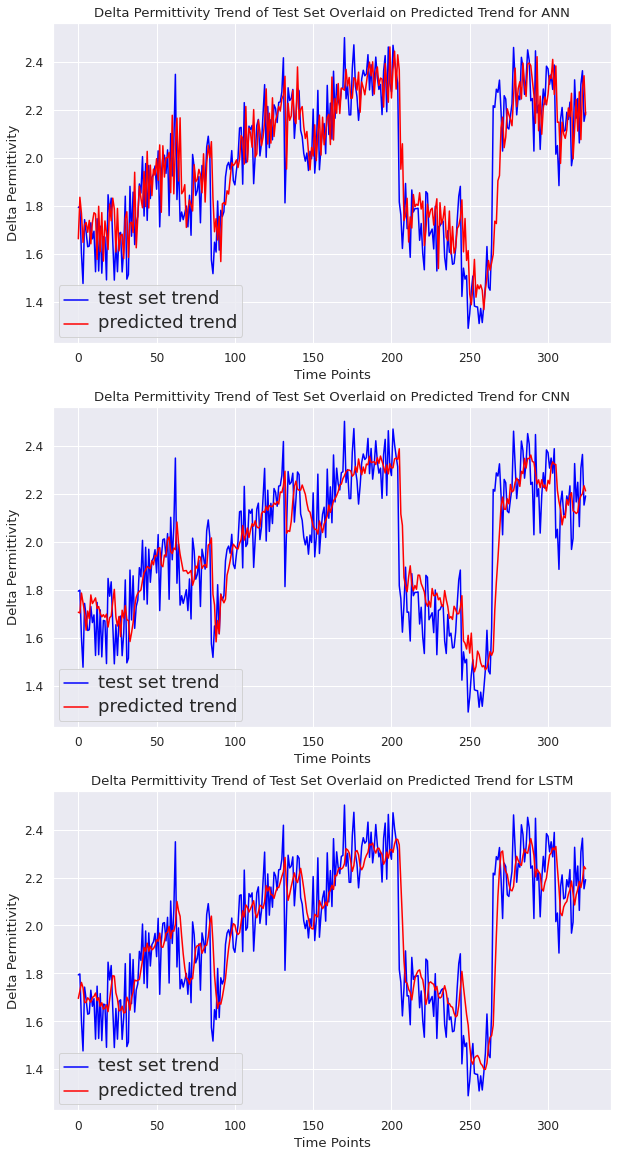

In [ ]:

f, ax = plt.subplots(3,1, figsize=(10, 20)) # type: Figure, Axes
n = range(len(ytest))
sns.set(font_scale=1.1)

sns.lineplot(x=n, y=ytest, label="test set trend", color="blue", ax=ax[0])
sns.lineplot(x=n, y=model.predict(xtest).flatten(), label="predicted trend", color="red", ax=ax[0])
ax[0].set_title("Delta Permittivity Trend of Test Set Overlaid on Predicted Trend for ANN")
ax[0].set_xlabel("Time Points")
ax[0].set_ylabel("Delta Permittivity")

sns.lineplot(x=n, y=ytest, label="test set trend", color="blue", ax=ax[1])
sns.lineplot(x=n, y=model_cnn.predict(xtest).flatten(), label="predicted trend", color="red", ax=ax[1])
ax[1].set_title("Delta Permittivity Trend of Test Set Overlaid on Predicted Trend for CNN")
ax[1].set_xlabel("Time Points")
ax[1].set_ylabel("Delta Permittivity")

sns.lineplot(x=n, y=ytest, label="test set trend", color="blue", ax=ax[2])
sns.lineplot(x=n, y=model_lstm.predict(xtest).flatten(), label="predicted trend", color="red", ax=ax[2])
ax[2].set_title("Delta Permittivity Trend of Test Set Overlaid on Predicted Trend for LSTM")
ax[2].set_xlabel("Time Points")
ax[2].set_ylabel("Delta Permittivity")


plt.setp(ax[0].get_legend().get_texts(), fontsize='18'); # for legend text
plt.setp(ax[1].get_legend().get_texts(), fontsize='18'); # for legend text
plt.setp(ax[2].get_legend().get_texts(), fontsize='18'); # for legend text
plt.show()